# PyTorch Tutorial 3 - Extracting Intermediate Representations from a Neural Network Model

Jinhyeok Jeong 
2024-06-11

For cognitive scientists who are interested in using neural network models as models of human cognition/perception, intermediate representations are often of interest.

There are three different methods of extracting intermediate representations from a pre-trained neural network model.

1. Modifying forward() or defining a new class

2. Using a hook function 

3. Using feature extraction function from torchvision

The first method is re-defining forward() function of the existing model or to define a new class of model that returns the activation of a certain layer. 
Here, I will focus on the last two methods because they are relatively easier than the first one. 

If you are interested in the first method or want to learn more about the differences between those methods, I recommend the following document:
https://pytorch.org/blog/FX-feature-extraction-torchvision/

Load packages

I will use t-SNE function from scikit-learn package for a later example, so you may wan to install it. See the following link to install scikit-learn.
https://scikit-learn.org/stable/install

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from torchsummary import summary

# https://scikit-learn.org/stable/install
from sklearn.manifold import TSNE

## Using hook function

Instead of modifying forward function or remove irrelevant layers, attaching a hook function to the network could be easier and flexible option.
https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
elif torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print(
            "MPS not available because the current Pytorch install was not build with MPS enabled."
        )
        device = torch.device("cpu")
    device = torch.device("mps")  # for MacOS devices with MPS support.
else:
    device = torch.device("cpu")
    print("CPU")

CPU


load pre-trained model

In [3]:
alexnet = torchvision.models.alexnet(
    weights="DEFAULT"
)  # for alexnet, DEFAULT = IMAGENET1K_V1
alexnet = alexnet.to(device)

In [4]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Let's say we are interested in the representation of a specific layer, 5th convolutional layer in the 'features' part of the AlexNet.

In [5]:
alexnet.features[-3]  # or alexnet.features[10]

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

You can attach hook function to view the activations without modifying the model.

https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html

'register_for_hook' takes user defined function as an argument, and can be applied for nn.Module. 

When forward() of the model is running, the attached hook function will be executed. 

The hook should have a following signature.

``` python

hook(module, input, output)

```

These arguments (module, input, output) will be passed to the hook via forward method. You don't have to put those arguments when registering the hook. See the following two example functions for hook


In [6]:
# If you don't need your own argument(s), you can make functiong like this:
# This function print the name of a layer's class and the shape of output
def print_outshape(module, input, output):
    print("type: ", type(module).__name__)  # get the name of nn.Module class
    print("shape: ", output.shape)  # print the output shape


# If you need your own argument(s), you make put the hook signature inside of your function:
# This function records the output of a layer in a list provided as an argument.
def get_activation(activation):
    # activation is a placeholder for saving activations

    # this is the actual hook function that will be run to record activation
    # In this case, you need to return this actual hook function at the end
    def hook(model, input, output):  # hook signature (model, input, ouput) is here
        activation.append(output.detach())

    return hook

Example of using hook (print the shape of output)

In [7]:
# register forward hook at the place where you want
h = alexnet.features[-3].register_forward_hook(print_outshape)

# run model (forward method will be used)
rand_input = torch.rand((1, 3, 224, 224)).to(device)
out = alexnet(rand_input)

# once you're done, you may want to remove the registered hook
h.remove()

type:  Conv2d
shape:  torch.Size([1, 256, 13, 13])


Example of using hook (get the activation and record it)

In [8]:
list_act = []

# register forward hook at the place where you want
h = alexnet.features[-3].register_forward_hook(get_activation(list_act))

# run model (forward method will be used)
rand_input = torch.rand((1, 3, 224, 224)).to(device)
out = alexnet(rand_input)

# once you're done, you may remove the registered hook
h.remove()

list_act[0]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[3.1941, 2.2595, 1.1003,  ..., 0.0000, 0.4127, 1.9446],
          [2.4965, 0.9805, 0.0000,  ..., 0.0000, 0.4132, 1.7456],
          [2.4877, 0.8120, 0.1290,  ..., 0.0000, 0.0000, 1.8356],
          ...,
          [2.0391, 1.2458, 0.0000,  ..., 0.0000, 0.0000, 0.8023],
          [2.6911, 2.0786, 0.6746,  ..., 0.4904, 0.0105, 1.2839],
          [4.0297, 2.2525, 1.2496,  ..., 1.2380, 0.7029, 3.1805]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

What if I want to get representations of all convolutional layers from feature component of alexnet?

In [9]:
hook_handles = []
list_act = []

for layer in alexnet.features:  # loop for layers in features component

    # check whether a given layer is 2D conv layer
    if isinstance(layer, nn.Conv2d):
        print(layer)

        hook_handles.append(layer.register_forward_hook(get_activation(list_act)))
        # layer.register_forward_hook(get_activation(list_act)) # if you don't care having hook handles, you can just do this.

# run model (forward method will be used)
rand_input = torch.rand((1, 3, 224, 224)).to(device)
out = alexnet(rand_input)

# check the list of activations
print([i.shape for i in list_act])

# remove hook handles if you don't need them anymore
for h in hook_handles:
    h.remove()
del hook_handles

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[torch.Size([1, 64, 55, 55]), torch.Size([1, 192, 27, 27]), torch.Size([1, 384, 13, 13]), torch.Size([1, 256, 13, 13]), torch.Size([1, 256, 13, 13])]


By using a hook, intermediate activations can be recorded. 

In addition, you may define your own function to examine and use the intermediate layers.

However, it only works for the nn.Modules, so it would be impossible to record the intermediate layers if they are not defined with nn.Modules
(e.g., if you use nn.functional modle to define a layer, you can't use a hook to access to that layer)

## Using feature extractor from torchvision


More recently developed and perhaps easier way to access to the intermediate representations is using feature extractor from torchvision.
It is under the FX submodule.

In order to use this method, you need to get the graphical representation of a flow of information in a neural network model.
You can get this information by using get_graph_node_names() function.

In [10]:
from torchvision.models.feature_extraction import (
    get_graph_node_names,
    create_feature_extractor,
)

# get the name of nodes
nodes, _ = get_graph_node_names(alexnet)
print(nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


Once you get the name of nodes (layers) that you are interested in, you can define feature extractor. The output would be a dictionary

In [11]:
# make feature extractor
feature_extractor = create_feature_extractor(alexnet, return_nodes=["features.10"])

# run the feature extractor
rand_input = torch.rand((1, 3, 224, 224)).to(device)
# out = alexnet(rand_input)
activation = feature_extractor(rand_input)

activation["features.10"].shape

torch.Size([1, 256, 13, 13])

If you want to get the activations of all convolutional layers, you need to know the names of nodes corresponding to conv layers.

0, 3, 6, 8, 10th layers are conv layers


In [12]:
alexnet.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [13]:
names_conv = [f"features.{i}" for i in [0, 3, 6, 8, 10]]

# make feature extractor
feature_extractor = create_feature_extractor(alexnet, return_nodes=names_conv)

# run the feature extractor
rand_input = torch.rand((1, 3, 224, 224)).to(device)
# out = alexnet(rand_input)
activation = feature_extractor(rand_input)

# check the dictionary of activations
print([i.shape for i in list_act])

activation

[torch.Size([1, 64, 55, 55]), torch.Size([1, 192, 27, 27]), torch.Size([1, 384, 13, 13]), torch.Size([1, 256, 13, 13]), torch.Size([1, 256, 13, 13])]


{'features.0': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0865, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.2286, 0.4926,  ..., 0.3030, 0.0000, 0.0000],
           [0.0000, 0.3448, 0.0000,  ..., 2.6201, 0.0000, 0.0000],
          

## Example: Extract intermediate representations for visualization

Here, I will show you an example of showing how to extract penultimate layer representations of a pre-trained alexnet (for Imagnet).
I will present images from CIFAR-10 imageset to the pretained alexnet, and visualize the extracted representations by using t-SNE. 

In [14]:
transform = transforms.Compose(
    [
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

batch_size = 10

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified


In [15]:
names = [f"features.{i}" for i in [0, 3, 6, 8, 10]] + [
    f"classifier.{i}" for i in [1, 4]
]

# make feature extractor
feature_extractor = create_feature_extractor(alexnet, return_nodes=names)

n_example = len(testset)
n_dim = alexnet.classifier[4].out_features

act_penultimate = []  # torch.zeros((n_example,n_dim))
correct_labels = []  # torch.zeros(n_example)

for i, data in enumerate(testloader, 0):

    inputs, labels = data

    # load data to GPU
    inputs = inputs.to(device)
    labels = labels.to(device)

    activation = feature_extractor(inputs)

    # detach() removes gradient information if exists, and cpu() take the tensor/model from GPU to CPU
    act_penultimate.append(activation["classifier.4"].detach().cpu())
    correct_labels.append(labels.detach().cpu())

# concat & make them as numpy
act_penultimate = torch.concat(act_penultimate, dim=0).numpy()
correct_labels = torch.concat(correct_labels).numpy()

print("shape of representations: ", act_penultimate.shape)
print("shape of labels: ", correct_labels)

# np.savez('cifar10_from_alexnet.npz',act_penultimate=act_penultimate,correct_labels=correct_labels)

shape of representations:  (10000, 4096)
shape of labels:  [3 8 8 ... 5 1 7]


I will use t-SNE to reduce the dimensionality of representations for visualization.

In [16]:
# with np.load('cifar10_from_alexnet.npz') as data:
#     acc_penultimate = data['acc_penultimate']
#     correct_labels = data['corret labels']

tsne = TSNE(n_components=2)
embedding = tsne.fit_transform(act_penultimate)
print(embedding.shape)

(10000, 2)


Although you can see a weak structure of penultimate representations indicating a category infomration, there are large overlap between the categories. 
Considering that the alexnet is not trained for CIFAR-10 images (it was trained for ImageNet), and that the original resolution of CIFAR-10 images is poor, this makes sense.

You will be able to get a clear result if you do a transfer learning.

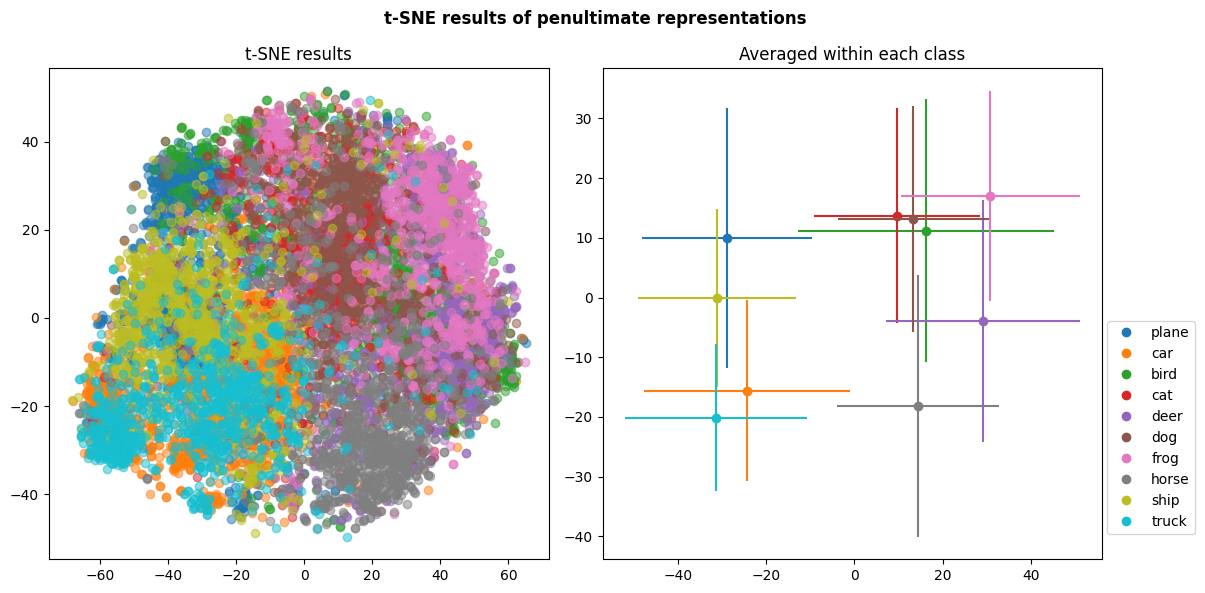

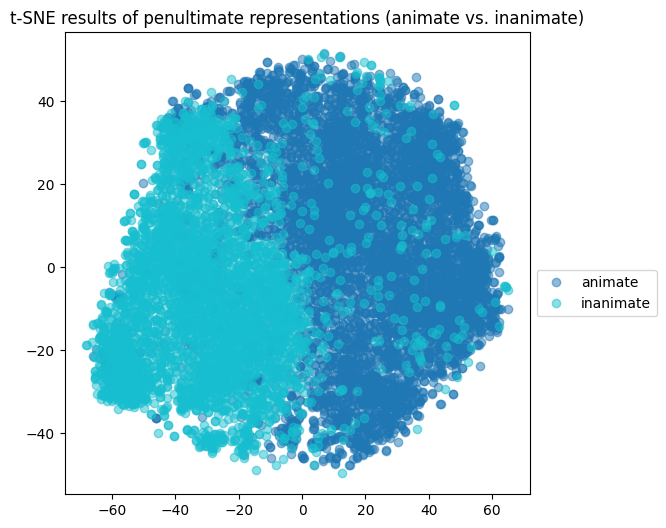

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    this_idx = np.argwhere(correct_labels == i)
    axs[0].plot(
        embedding[this_idx, 0],
        embedding[this_idx, 1],
        "o",
        label=classes[i],
        color=colors[i],
        alpha=0.5,
    )
    # plt.legend(bbox_to_anchor=(1,0.5))
    # plt.show()

    this_m = embedding[this_idx, :].mean(axis=0).reshape(-1)
    this_sd = embedding[this_idx, :].std(axis=0, ddof=1).reshape(-1)

    axs[1].plot(this_m[0], this_m[1], "o", label=classes[i], color=colors[i])
    axs[1].errorbar(
        this_m[0], this_m[1], yerr=this_sd[1], xerr=this_sd[0], color=colors[i]
    )

axs[0].set_title("t-SNE results")
axs[1].set_title("Averaged within each class")
plt.suptitle("t-SNE results of penultimate representations", fontweight="bold")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.tight_layout()
plt.show()

classes2 = ("animate", "inanimate")
# animate: 2, 3, 4, 5, 6, 7 --> 0
# inanimate: 0, 1, 8, 9 --> 1
correct_labels2 = np.where(np.isin(correct_labels, [2, 3, 4, 5, 6, 7]), 0, 1)

plt.figure(figsize=(6, 6))
colors2 = plt.cm.tab10(np.linspace(0, 1, 2))

for i in range(2):
    this_idx = np.argwhere(correct_labels2 == i)
    plt.plot(
        embedding[this_idx, 0],
        embedding[this_idx, 1],
        "o",
        label=classes2[i],
        color=colors2[i],
        alpha=0.5,
    )
plt.legend(bbox_to_anchor=(1, 0.5))
plt.title("t-SNE results of penultimate representations (animate vs. inanimate)")
plt.show()